# Load important Packages

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Prepare stopwords

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words = set(stop_words)

# Import dataset

In [7]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


# Data processing

In [8]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I '
 'saw the other day. It was a 2-door sports car, looked to be from the late '
 '60s/ early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


# Tokenize words and Clean-up text

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [27]:
print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


# Creating Bigram and Trigram Models

In [10]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/data/1/anurag/mlEnv/lib/python3.4/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [11]:
print(bigram_mod[data_words[0]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting', 'host', 'rac_wam', 'umd_edu', 'organization', 'university', 'of', 'maryland_college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


#  Remove Stopwords, Make Bigrams and Lemmatize

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [28]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_post', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'whatev', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


# Create the Dictionary and Corpus needed for Topic Modeling

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) below implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

In [36]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]


If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [38]:
id2word[0]

'addition'

In [39]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('maryland_college', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_post', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('whatev', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

# Building the Topic Model

In [40]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model

- Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

- It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

- The weights reflect how important a keyword is to that topic.

In [41]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"_" + 0.029*"blue" + 0.021*"tank" + 0.014*"cubs_suck" + 0.012*"eg" '
  '+ 0.012*"gas" + 0.011*"hi" + 0.007*"henry_spencer" + 0.007*"cigarette" + '
  '0.006*"xlib"'),
 (1,
  '0.020*"value" + 0.020*"bus" + 0.019*"specifically" + 0.015*"function" + '
  '0.015*"associate" + 0.013*"motorcycle" + 0.011*"properly" + 0.010*"code" '
  '+ 0.008*"confuse" + 0.008*"error"'),
 (2,
  '0.023*"window" + 0.020*"card" + 0.017*"file" + 0.014*"drive" + '
  '0.013*"use" + 0.013*"system" + 0.011*"problem" + 0.010*"run" + '
  '0.009*"color" + 0.009*"do"'),
 (3,
  '0.035*"game" + 0.033*"team" + 0.019*"player" + 0.017*"play" + '
  '0.017*"win" + 0.016*"hockey" + 0.013*"season" + 0.011*"contact" + '
  '0.011*"year" + 0.010*"nhl"'),
 (4,
  '0.026*"wire" + 0.017*"circuit" + 0.015*"faq" + 0.015*"connect" + '
  '0.013*"wiring" + 0.013*"voice" + 0.012*"cover" + 0.011*"outlet" + '
  '0.011*"neutral" + 0.010*"conference"'),
 (5,
  '0.030*"government" + 0.024*"gun" + 0.022*"law" + 0.017*"state" + '
  '0.0

#  Compute Model Perplexity and Coherence Score

In [48]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.754127161537046

Coherence Score:  0.515758393754623


# Visualize the topics-keywords

In [49]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      16.256056        1       1  0.336962 -0.001278
13     15.227037        1       2  0.291064 -0.003112
18     14.573561        1       3  0.328797 -0.128185
2       6.162454        1       4  0.091782  0.226445
15      5.973614        1       5  0.059668  0.222609
10      4.344126        1       6 -0.084990 -0.112871
17      4.177887        1       7  0.060969 -0.182988
12      3.586121        1       8 -0.022523 -0.036463
5       3.365479        1       9 -0.022905 -0.021274
16      3.271730        1      10 -0.029277  0.219740
6       3.227741        1      11 -0.062706 -0.017226
9       2.969712        1      12 -0.062841  0.139474
14      2.741300        1      13 -0.088859 -0.062624
3       2.731812        1      14 -0.047751 -0.117467
8       2.290854        1      15 -0.111493  0.003703
19      2.124065        1      16 -0.113682 -0.023370
11      2.081741        1      17 -0.092188 -0.110820
4       1.693805        1      18 -0.134206  0.001654
0       1.679179        1      19 -0.164202 -0.027968
1       1.521721        1      20 -0.131621  0.032020, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
43449  Default  57084.000000            ax  57084.000000  30.0000  30.0000
35767  Default  12491.000000          line  12491.000000  29.0000  29.0000
18464  Default  16294.000000           not  16294.000000  28.0000  28.0000
4160   Default  11142.000000  organization  11142.000000  27.0000  27.0000
26312  Default   3845.000000           max   3845.000000  26.0000  26.0000
20646  Default  10454.000000            do  10454.000000  25.0000  25.0000
10546  Default   9655.000000         write   9655.000000  24.0000  24.0000
33586  Default   7586.000000       article   7586.000000  23.0000  23.0000
37412  Default   8048.000000            be   8048.000000  22.0000  22.0000
38129  Default  11783.000000         would  11783.000000  21.0000  21.0000
63688  Default   6906.000000           say   6906.000000  20.0000  20.0000
55664  Default   5804.000000            go   5804.000000  19.0000  19.0000
22536  Default   4407.000000     nntp_post   4407.000000  18.0000  18.0000
9176   Default   4083.000000          host   4083.000000  17.0000  17.0000
45949  Default   6852.000000           get   6852.000000  16.0000  16.0000
7862   Default   5027.000000    university   5027.000000  15.0000  15.0000
27920  Default   1863.000000         space   1863.000000  14.0000  14.0000
50843  Default   2294.000000        window   2294.000000  13.0000  13.0000
58004  Default   3735.000000             s   3735.000000  12.0000  12.0000
49803  Default   7292.000000          know   7292.000000  11.0000  11.0000
29964  Default   3461.000000          year   3461.000000  10.0000  10.0000
43457  Default   4598.000000           use   4598.000000   9.0000   9.0000
68356  Default   1540.000000          game   1540.000000   8.0000   8.0000
673    Default   1948.000000          mail   1948.000000   7.0000   7.0000
49680  Default   3006.000000         right   3006.000000   6.0000   6.0000
39720  Default   1684.000000     christian   1684.000000   5.0000   5.0000
64720  Default   1746.000000    government   1746.000000   4.0000   4.0000
19231  Default   1464.000000          team   1464.000000   3.0000   3.0000
69104  Default   3380.000000        system   3380.000000   2.0000   2.0000
31754  Default   2012.000000          card   2012.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
66371  Topic20    119.370811          guru    120.322693   4.1774  -5.3259
64987  Topic20    117.623329  countersteer    118.575211   4.1773  -5.3407
16203  Topic20    113.025970       bradley    113.977852   4.1769  -5.3805
54739  Topic20    112.216629          lane    113.168510   4.1769  -5

# Building LDA Mallet Model

In [51]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/data/1/anurag/topic-modeling/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [56]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(14,
  [('people', 0.03238665877435643),
   ('make', 0.03212089730735314),
   ('good', 0.03052632850533335),
   ('thing', 0.028823039103175848),
   ('point', 0.019146905690919414),
   ('write', 0.017987219289450476),
   ('time', 0.014532320218407606),
   ('give', 0.01337263381693867),
   ('bad', 0.010606298546767978),
   ('reason', 0.009881494545849892)]),
 (15,
  [('year', 0.024461963090577816),
   ('good', 0.019988093734778924),
   ('run', 0.014016921328450562),
   ('game', 0.011040355023181138),
   ('hit', 0.010679559107390905),
   ('win', 0.0091281366694929),
   ('organization', 0.008911659120018761),
   ('team', 0.007360236682120758),
   ('lose', 0.0073061172947522235),
   ('line', 0.007143759132646618)]),
 (7,
  [('window', 0.019886363636363636),
   ('image', 0.011698540280857353),
   ('file', 0.011121119733924613),
   ('program', 0.011121119733924613),
   ('display', 0.00975840724316334),
   ('version', 0.009146341463414634),
   ('server', 0.008095436067997043),
   ('graphic', 

In [57]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.6480616073889326


# How to find the optimal number of topics for LDA?

In [58]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [59]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

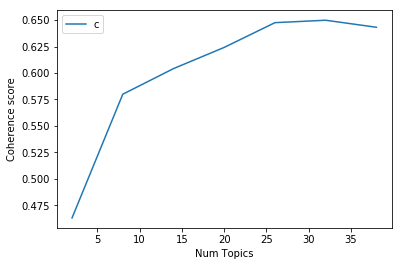

In [60]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

In [61]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4629
Num Topics = 8  has Coherence Value of 0.5799
Num Topics = 14  has Coherence Value of 0.6041
Num Topics = 20  has Coherence Value of 0.6242
Num Topics = 26  has Coherence Value of 0.6476
Num Topics = 32  has Coherence Value of 0.6499
Num Topics = 38  has Coherence Value of 0.6432


In [62]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.049*"good" + 0.046*"write" + 0.038*"article" + 0.034*"make" + '
  '0.027*"thing" + 0.017*"line" + 0.017*"people" + 0.016*"bad" + '
  '0.016*"lot" + 0.015*"time"'),
 (1,
  '0.018*"time" + 0.016*"day" + 0.014*"people" + 0.012*"back" + '
  '0.011*"leave" + 0.011*"happen" + 0.010*"start" + 0.009*"man" + '
  '0.008*"home" + 0.008*"call"'),
 (2,
  '0.034*"window" + 0.012*"file" + 0.012*"run" + 0.012*"program" + '
  '0.011*"display" + 0.010*"application" + 0.009*"color" + 0.009*"version" '
  '+ 0.009*"set" + 0.009*"server"'),
 (3,
  '0.013*"people" + 0.012*"write" + 0.012*"state" + 0.010*"israel" + '
  '0.010*"article" + 0.009*"israeli" + 0.008*"arab" + 0.008*"opinion" + '
  '0.008*"attack" + 0.007*"question"'),
 (4,
  '0.013*"government" + 0.010*"make" + 0.009*"president" + 0.009*"work" + '
  '0.008*"people" + 0.006*"american" + 0.006*"encryption" + 0.006*"money" + '
  '0.006*"job" + 0.005*"technology"'),
 (5,
  '0.025*"game" + 0.018*"team" + 0.015*"year" + 0.014*"play" + '
  '0.01

# Finding the dominant topic in each sentence

In [63]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.1725,"car, bike, drive, organization, engine, dod, r...",From: (wheres my thing) Subject: WHAT car is t...
1,1,11.0,0.2057,"drive, card, system, problem, mac, driver, scs...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,18.0,0.3276,"car, bike, drive, organization, engine, dod, r...",From: (Irwin Arnstein) Subject: Re: Recommenda...
3,3,2.0,0.4021,"window, file, run, program, display, applicati...",From: (Tsung-Kun Chen) Subject: ** Software fo...
4,4,11.0,0.2039,"drive, card, system, problem, mac, driver, scs...",From: (Don A.B. Lindbergh) Subject: Diamond SS...
5,5,18.0,0.3862,"car, bike, drive, organization, engine, dod, r...",From: (Robert Loper) Subject: Re: SHO and SC N...
6,6,14.0,0.1948,"line, organization, nntp_post, host, mail, sal...",From: (Kim Richard Man) Subject: SyQuest 44M c...
7,7,14.0,0.1997,"line, organization, nntp_post, host, mail, sal...",From: (Kirtley Wilson) Subject: Mirosoft Offic...
8,8,3.0,0.1565,"people, write, state, israel, article, israeli...",Subject: Re: Dont more innocents die without t...
9,9,10.0,0.2472,"god, christian, people, religion, bible, word,...",From: (Jon Livesey) Subject: Re: Genocide is C...


# Find the most representative document for each topic

In [65]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3719,"good, write, article, make, thing, line, peopl...",From: (John F Nielsen) Subject: Re: top 10 rea...
1,1.0,0.8917,"time, day, people, back, leave, happen, start,...",From: (David Davidian) Subject: Accounts of An...
2,2.0,0.7848,"window, file, run, program, display, applicati...",From: (David B. Lewis) Subject: comp.windows.x...
3,3.0,0.8095,"people, write, state, israel, article, israeli...",From: Center for Policy Research Subject: Fina...
4,4.0,0.8276,"government, make, president, work, people, ame...",From: (Clinton/Gore 92) Subject: CLINTON: Back...
5,5.0,0.9297,"game, team, year, play, player, win, season, g...",From: (Rocket) Subject: NHL Final point standi...
6,6.0,0.9813,"_, organization, line, ca, cx, air, newsreader...",Subject: roman 02/14 From: (Cliff) Reply-To: (...
7,7.0,0.4513,"line, organization, write, university, article...",From: (brian manning delaney) Subject: RESULT:...
8,8.0,0.7905,"point, write, book, question, science, system,...","From: (Jeff Mason) Subject: Marvel, DC, Valian..."
9,9.0,0.7534,"key, file, information, system, mail, image, s...",From: Marc VanHeyningen Subject: RIPEM Frequen...


# Topic distribution across documents

In [98]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[["Topic_Num", "Keywords"]]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.sort_index(), topic_contribution.sort_index()], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"good, write, article, make, thing, line, peopl...",194,0.0171
1,1.0,"time, day, people, back, leave, happen, start,...",175,0.0155
2,2.0,"window, file, run, program, display, applicati...",864,0.0764
3,3.0,"people, write, state, israel, article, israeli...",368,0.0325
4,4.0,"government, make, president, work, people, ame...",549,0.0485
5,5.0,"game, team, year, play, player, win, season, g...",1055,0.0932
6,6.0,"_, organization, line, ca, cx, air, newsreader...",142,0.0126
7,7.0,"line, organization, write, university, article...",652,0.0576
8,8.0,"point, write, book, question, science, system,...",360,0.0318
9,9.0,"key, file, information, system, mail, image, s...",540,0.0477
